# About the Project:

This code is for the study of Perceptron Model using the library scikit-learn. 

In [1]:
# Loading the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
# The file path to the dataset
file_path = "./data/diabetes.csv"

# Load the data
dataset = pd.read_csv(file_path)

# Display the first 5 rows of the dataset
dataset.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### Data Cleaning

In [4]:
# It has some values as 0, which is not possible for some columns like Glucose, BloodPressure, SkinThickness, Insulin, and BMI.
# We will replace these values with NaN. 

# The columns which had impossible values are Glucose, BloodPressure, SkinThickness, Insulin, and BMI (this is being saved in a list)
uncleaned_columns = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# Replace 0 with NaN
dataset[uncleaned_columns] = dataset[uncleaned_columns].replace(0, pd.NA)

# Now let's replace the NaN values with the median of the columns 
dataset.fillna(dataset.median(), inplace=True)

# Now, making sure the data has no null values
dataset.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [5]:
#  Now, we will split the data into features and target variable.

X = dataset.loc[:, dataset.columns != 'Outcome']
y = dataset.loc[:, 'Outcome']

# Shape of X and y, will tell us the number of rows and columns in the dataset
X.shape, y.shape

((768, 8), (768,))

In [6]:
# Checking the datatypes of the columns
X.dtypes

Pregnancies                   int64
Glucose                     float64
BloodPressure               float64
SkinThickness               float64
Insulin                     float64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
dtype: object

### Visualizing the dataset

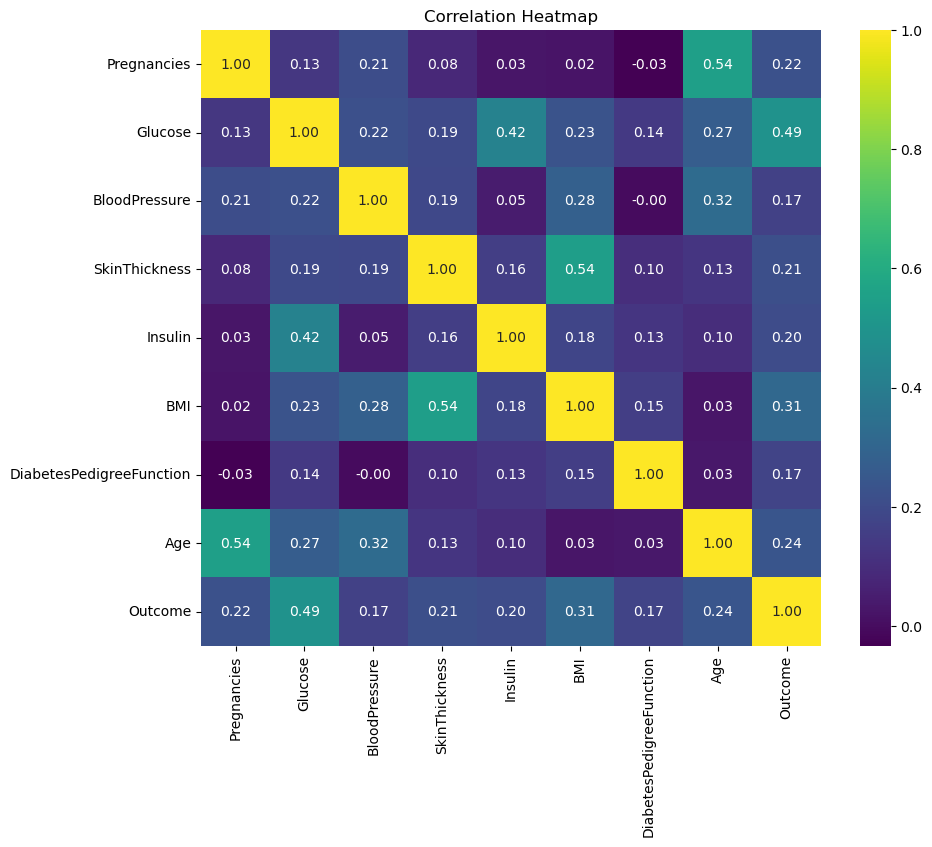

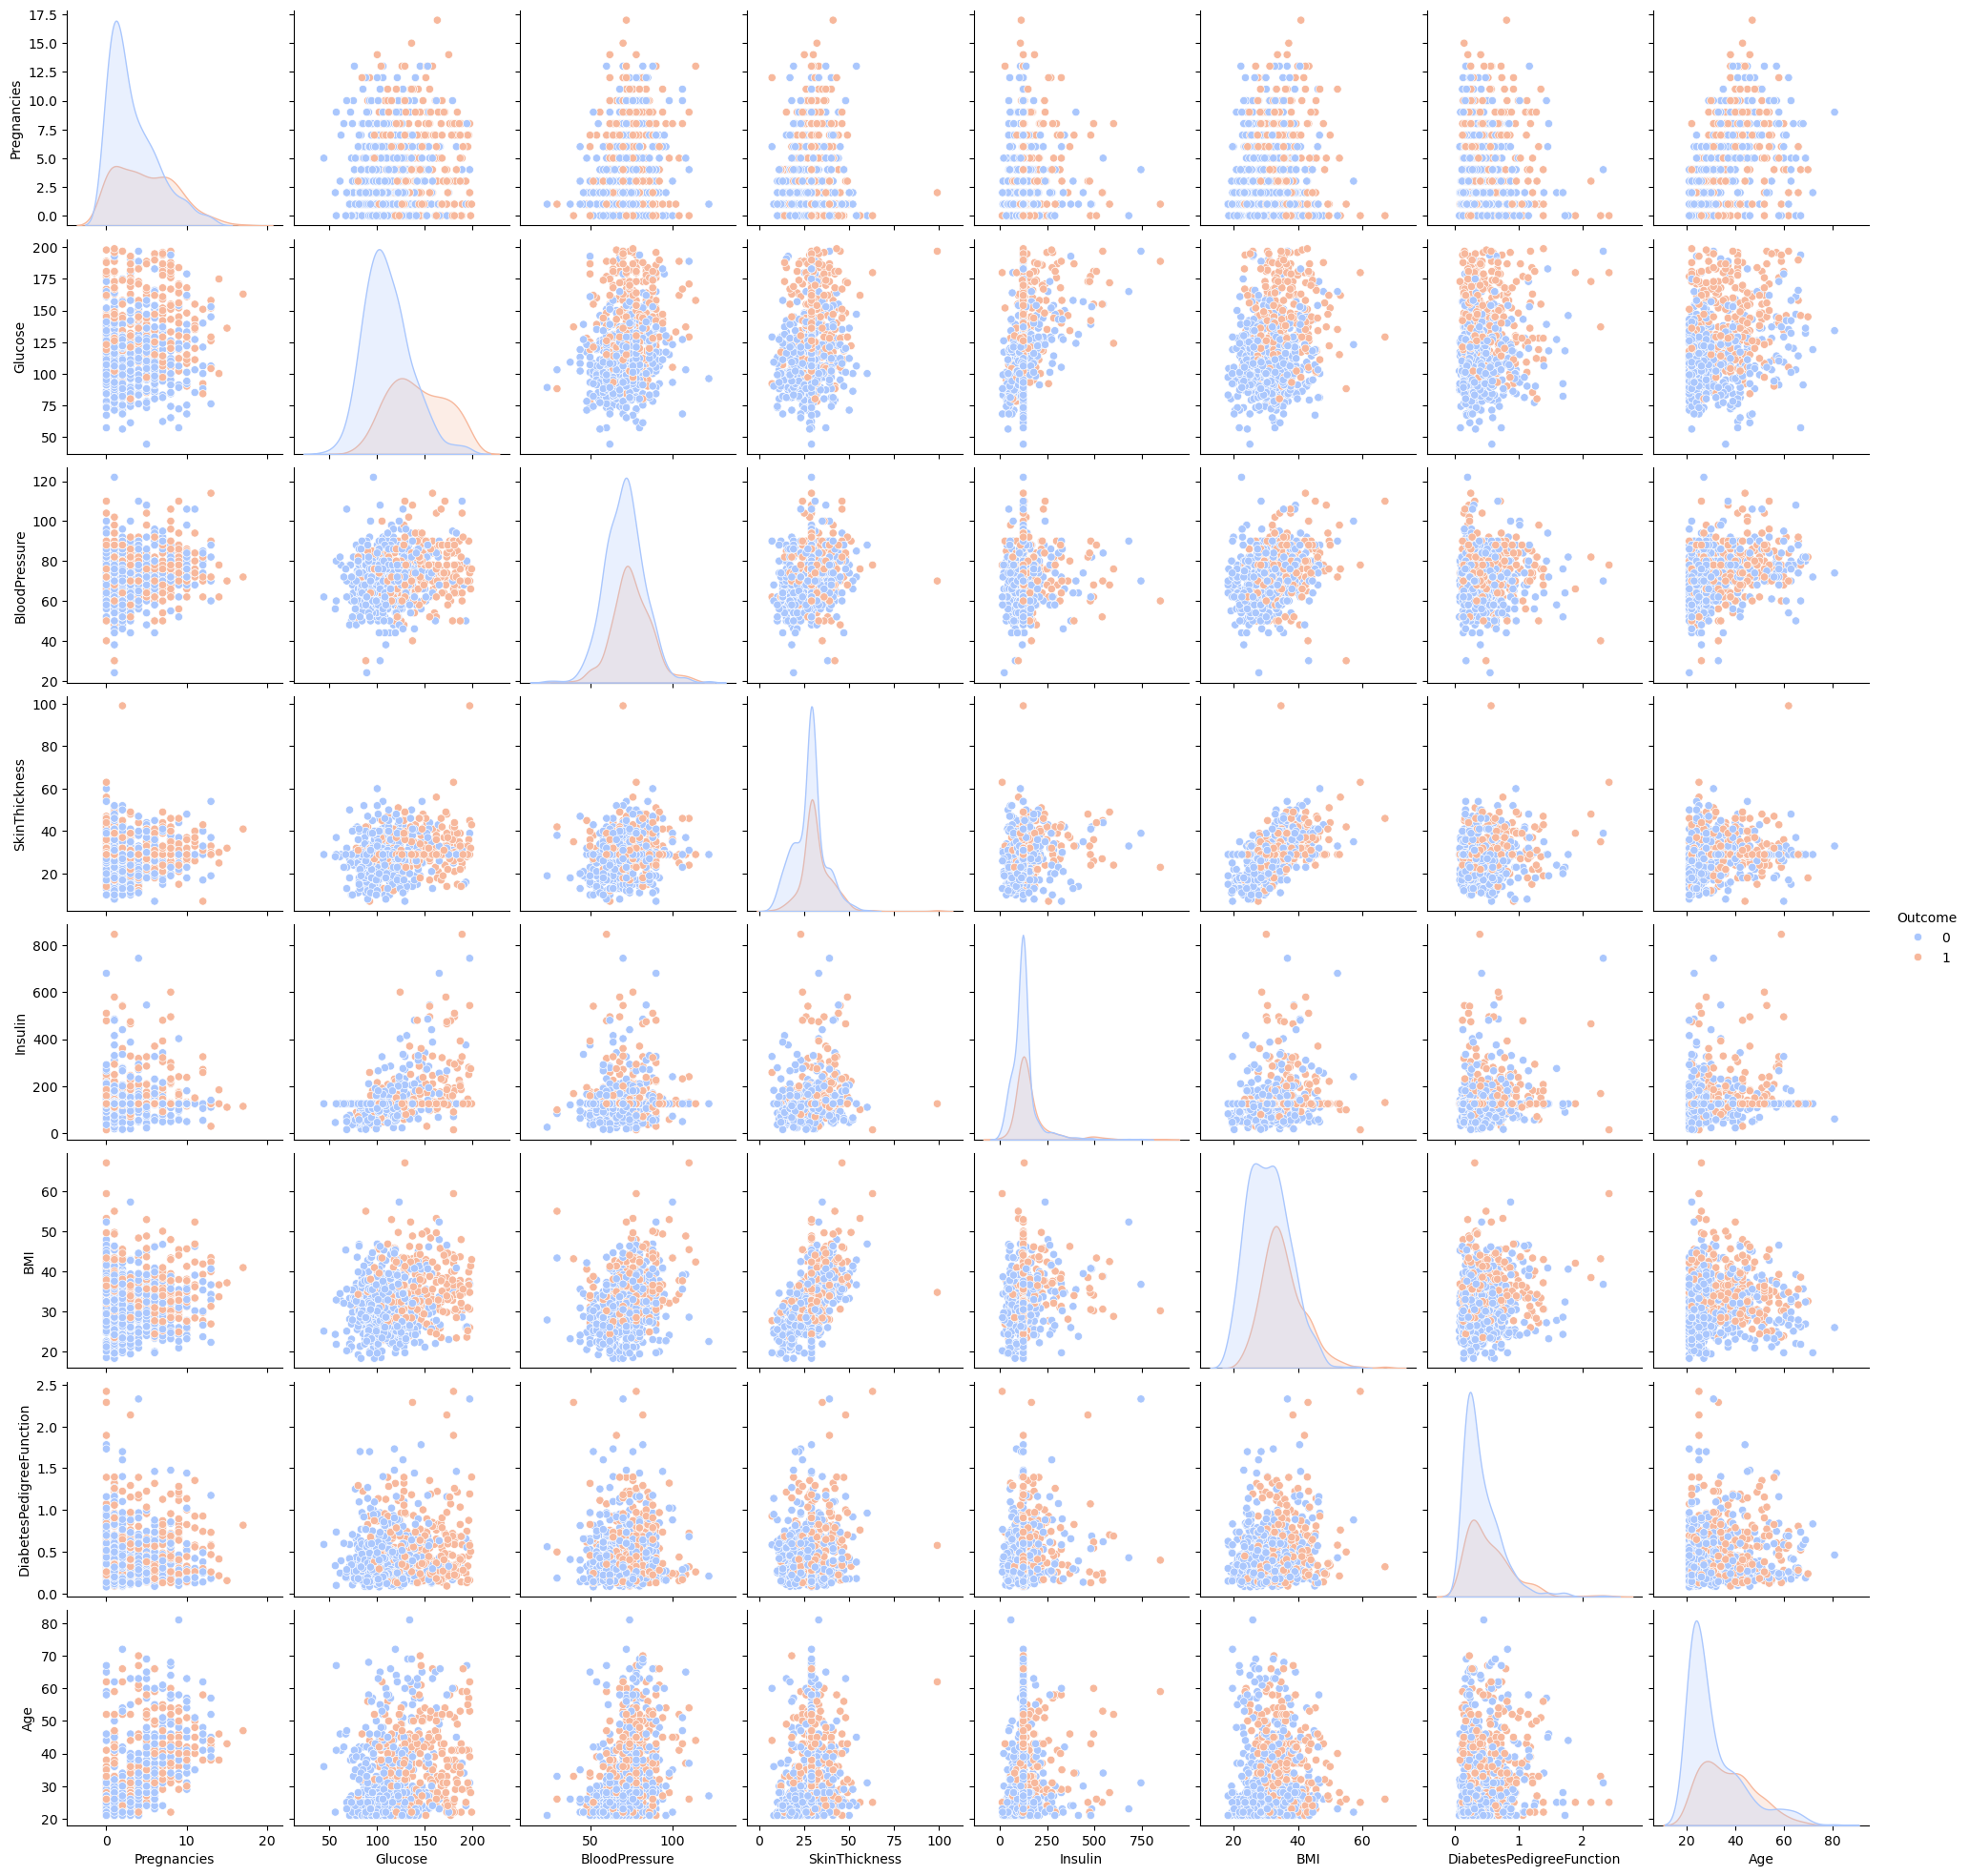

In [7]:
# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
correlation_matrix = dataset.corr()

# Heatmap for correlations
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


# Pair plot for relationships between variables and the target
sns.pairplot(dataset, hue='Outcome', palette='coolwarm')
plt.show()


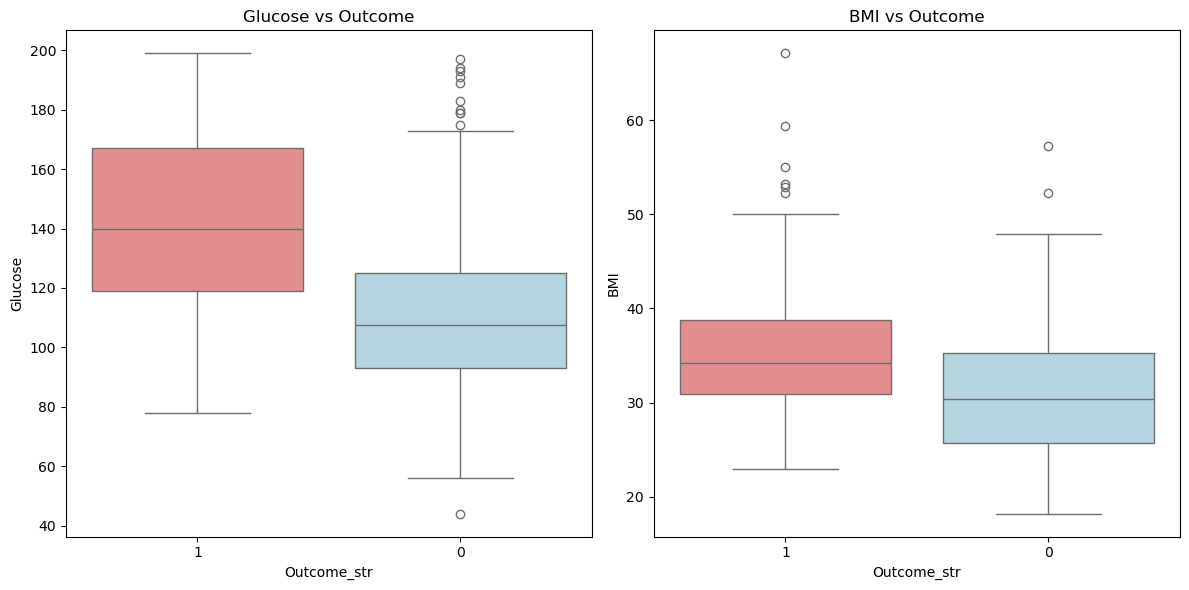

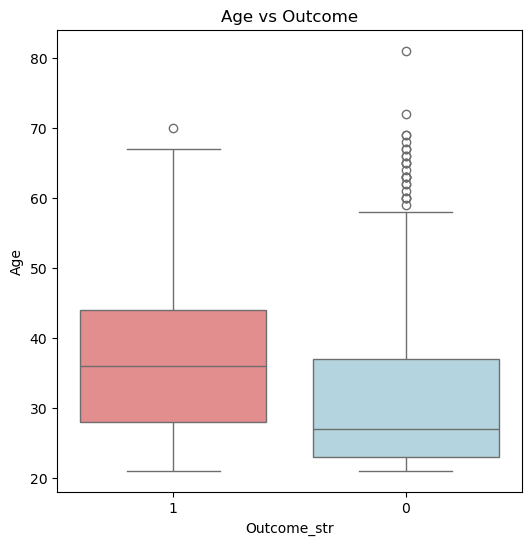

In [8]:
# Convert Outcome values to strings to match the palette dictionary for different colors
dataset['Outcome_str'] = dataset['Outcome'].astype(str)

# Defining a custom color pallette
palette = {"0": "lightblue", "1": "lightcoral"}

plt.figure(figsize=(12, 6))

# Glucose vs Outcome with custom colors
plt.subplot(1, 2, 1)
sns.boxplot(x='Outcome_str', y='Glucose', data=dataset, palette=palette)
plt.title('Glucose vs Outcome')

# BMI vs Outcome with custom colors
plt.subplot(1, 2, 2)
sns.boxplot(x='Outcome_str', y='BMI', data=dataset, palette=palette)
plt.title('BMI vs Outcome')

plt.tight_layout()
plt.show()

# Age vs Outcome with custom colors
plt.figure(figsize=(6, 6))
sns.boxplot(x='Outcome_str', y='Age', data=dataset, palette=palette)
plt.title('Age vs Outcome')
plt.show()


### Preprocessing the data

This is being done, as the requested output format is from -1 to +1 by the client.

In [9]:
# Since the predictions are based on -1 and +1, updating the labels below
y = y.replace({0: -1, 1: 1})

# Scaling the features to have a similar scale of range. 
scaler = RobustScaler()

X = scaler.fit_transform(X)

### Baseline Model

The Baseline Model implementation using sklearn that calculates the weight by using Gradient Descent until convergence or 1000 epochs.

In [10]:
# Baseline Model 
# Split the dataset from train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Perceptron model
baseline_model = Perceptron()

# Training the model
baseline_model.fit(X_train, y_train)

# Predicting on test set
y_pred = baseline_model.predict(X_test)

# Performance Metrics for the Baseline Model
baseline_accuracy = accuracy_score(y_test, y_pred)
baseline_precision = precision_score(y_test, y_pred)
baseline_recall = recall_score(y_test, y_pred)
baseline_f1 = f1_score(y_test, y_pred)

performance_metrics = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Score': [baseline_accuracy, baseline_precision, baseline_recall, baseline_f1]
})

performance_metrics

,Metric,Score
0,Accuracy,0.714286
1,Precision,0.593220
2,Recall,0.636364
3,F1 Score,0.614035


In [11]:
# Extracting the weights and bias from the model
weights_baseline = baseline_model.coef_[0]
bias_baseline = baseline_model.intercept_[0]

print(f"The weights of the baseline model are: {weights_baseline}, and the bias is: {bias_baseline}")

The weights of the baseline model are: [12.4        42.79012346 -9.6875     19.57142857 -0.52173913 23.89010989
  9.58039216 27.52941176], and the bias is: -43.0


## Experimental Analysis:

- Experimental analysis is conducted to explore loss functions that when used with SGD works as a Perceptron. 
- The use of SGD is made, as it is faster than the traditional gradient because of its ability to caluclate the slope faster with the aid of small batches of dataset. 
- The use of GridSearchCV is deployed to test the model with various hyperparameters and choosing the best set of parameters. 

### HyperParameter Tuning 

In [12]:
# Deifining a wider range of hyperparameters for the Perceptron model 
parameters_perceptron_loss = {
    'penalty': ['l2', 'l1', 'elasticnet'],  
    'alpha': [0.0001, 0.001, 0.01, 0.1],   
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    'eta0': [0.1, 0.01, 0.001, 0.0001]     
}

# Performing the Grid Search using the SGD classifier with Perceptron loss
perceptron_model = SGDClassifier(loss='perceptron', random_state=42)
perceptron_grid_search = GridSearchCV(perceptron_model, parameters_perceptron_loss, cv=5, scoring='accuracy')
perceptron_grid_search.fit(X_train, y_train)

# From K-Fold Cross Validation, extracting the best parameters and score
best_perceptron_parameter = perceptron_grid_search.best_params_
best_perceptron_score = perceptron_grid_search.best_score_

# Training the model with the best parameters and evaluating on the test set
best_perceptron_loss_model = SGDClassifier(loss='perceptron', random_state=42, **best_perceptron_parameter)
best_perceptron_loss_model.fit(X_train, y_train)
y_pred_perceptron_loss = best_perceptron_loss_model.predict(X_test)

# Evaluating the performance of the best model with Perceptron loss
accuracy_perceptron_loss = accuracy_score(y_test, y_pred_perceptron_loss)
precision_perceptron_loss = precision_score(y_test, y_pred_perceptron_loss)
recall_perceptron_loss = recall_score(y_test, y_pred_perceptron_loss)
f1_perceptron_loss = f1_score(y_test, y_pred_perceptron_loss)

# Storing the metrics in a DataFrame
performance_table_perceptron = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Best Parameters'],
    'Best Perceptron Score': [accuracy_perceptron_loss, precision_perceptron_loss, recall_perceptron_loss, f1_perceptron_loss, str(best_perceptron_parameter)]
})

pd.options.display.max_colwidth = None

performance_table_perceptron


,Metric,Best Perceptron Score
0,Accuracy,0.753247
1,Precision,0.644068
2,Recall,0.690909
3,F1 Score,0.666667
4,Best Parameters,"{'alpha': 0.001, 'eta0': 0.0001, 'learning_rate': 'adaptive', 'penalty': 'elasticnet'}"


In [13]:
# Extarcting the weights and bias from the Perceptron Loss Model 
weights_perceptron = best_perceptron_loss_model.coef_[0]  
bias_perceptron = best_perceptron_loss_model.intercept_[0]

print(f"The weights of the features are: {weights_perceptron}, and the bias is: {bias_perceptron}")

The weights of the features are: [ 1.42105061e-04  8.35095552e-04 -3.15964439e-04  2.67724569e-06
  0.00000000e+00  5.53005348e-04  2.08696154e-04  3.99524711e-04], and the bias is: -0.0006279999999999878


### Applying Binary-Cross Entropy loss

In [14]:
# Deifining a wider range of hyperparameters for the Perceptron model using (Binary Cross-Entropy)
parameter_log_loss = {
    'penalty': ['l2', 'l1', 'elasticnet'],  
    'alpha': [0.0001, 0.001, 0.01, 0.1],   
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    'eta0': [0.1, 0.01, 0.001, 0.0001]     
}

# Performing the Grid Search using the SGD classifier with Binary Cross-Entropy loss
perceptron_log_loss = SGDClassifier(loss='log_loss', random_state=42) 
log_loss_grid_search = GridSearchCV(perceptron_log_loss, parameter_log_loss, cv=5, scoring='accuracy')
log_loss_grid_search.fit(X_train, y_train)

# From K-Fold Cross Validation, extracting the best parameters and score
best_log_loss_parameter = log_loss_grid_search.best_params_
best_log_loss_score = log_loss_grid_search.best_score_

# Training the model with the best parameters and evaluating on the test set
best_log_loss_model = SGDClassifier(loss='log_loss', random_state=42, **best_log_loss_parameter)
best_log_loss_model.fit(X_train, y_train)
y_pred_log_loss = best_log_loss_model.predict(X_test)

# Evaluating the performance of the best model with Perceptron loss
accuracy_log_loss = accuracy_score(y_test, y_pred_log_loss)
precision_log_loss = precision_score(y_test, y_pred_log_loss)
recall_log_loss = recall_score(y_test, y_pred_log_loss)
f1_log_loss = f1_score(y_test, y_pred_log_loss)

# Storing the metrics in a DataFrame
performance_table_log = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Best Parameters'],
    'Best Log Loss Score': [accuracy_log_loss, precision_log_loss, recall_log_loss, f1_log_loss, str(best_log_loss_parameter)]
})

performance_table_log


,Metric,Best Log Loss Score
0,Accuracy,0.75974
1,Precision,0.68
2,Recall,0.618182
3,F1 Score,0.647619
4,Best Parameters,"{'alpha': 0.01, 'eta0': 0.1, 'learning_rate': 'optimal', 'penalty': 'elasticnet'}"


In [15]:
# Extracting the weights and bias from the Binary Cross-Entropy Loss Model 
weights_log = best_log_loss_model.coef_[0]
bias_log = best_log_loss_model.intercept_[0]

print(f"The weights of the features are: {weights_log}, and the bias is: {bias_log}")

The weights of the features are: [ 0.30353104  1.30476352 -0.08333075  0.09730264  0.          0.75329198
  0.20140237  0.50601878], and the bias is: -1.2193801724719422
